## NLP with DL

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Datasets/hepsiburada.csv')

In [5]:
df.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


In [6]:
df.info()

# nan degerleri dropna ile dusurmemiz gerekirdi
# nlp'de null degerleri doldurma yok

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243497 entries, 0 to 243496
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Rating  243497 non-null  int64 
 1   Review  243497 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [7]:
df.Rating.value_counts()

# olumlu yorumlar 1, olumsuzlar 0

1    229821
0     13676
Name: Rating, dtype: int64

In [8]:
df.Rating = df.Rating.map({1:0, 0:1})

# bizim hedef label'imiz kac ise onu 1 yapmaliyiz
# burada bizim hedef label'imiz negatif degerler oldugu icin onu 1 olarak degistirdik

In [9]:
df.Rating.value_counts()

0    229821
1     13676
Name: Rating, dtype: int64

In [10]:
pd.Series(df.Rating).value_counts(normalize=True)

# burada dengesiz bir data seti var elimde
# elimizdeki verilerin %5'i olumsuz ve onun label'ini 1 olarak atadik

0    0.943835
1    0.056165
Name: Rating, dtype: float64

## Tokenization

In [11]:
X = df['Review'].values
y = df['Rating'].values

# deep learning modelleri array olarak bekler modele, bu sebeple array yapiyoruz

In [12]:
num_words = 15000 

# genelde deep learning uygulamalarinda corpus icinde en fazla gecen 10000-15000 token'i kullaniyoruz, cunku tum
# token'lari kullanmamiz durumunda makinamiza cok yuklenmis oluruz. Default'u none'dir yani corpus'taki tum tokenler

# corpusta geçen en fazla kullanılan ilk 15000 kelimeyi(tokeni) alacağız gerisini yok sayacağız. 
# None değeri atanırsa tüm kelimeler dikkate alınır.

tokenizer = Tokenizer(num_words=num_words) 

# tokenizer kendisi kucuk harfe donusturuyor
# filters ile de neyi temizlemek istiyorsak onu belirtiyoruz, default filter'in icine kendi istediklerimizi ekleyebiliriz
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'
# deep learning modellerinde stop words ve lemmatization'a gerek yok 

In [13]:
tokenizer.fit_on_texts(X)

## Creating word index

In [14]:
tokenizer.word_index

# corpus'umda en fazla kullanilan token'i 1'den baslayarak asagiya siraliyor
# biraz sonra modelim her token'i yanindaki sayiya donusturecek

{'çok': 1,
 'bir': 2,
 've': 3,
 'ürün': 4,
 'bu': 5,
 'iyi': 6,
 'güzel': 7,
 'için': 8,
 'tavsiye': 9,
 'ederim': 10,
 'daha': 11,
 'ama': 12,
 'da': 13,
 'gayet': 14,
 'hızlı': 15,
 'teşekkürler': 16,
 'aldım': 17,
 'de': 18,
 'ürünü': 19,
 'gibi': 20,
 'yok': 21,
 'uygun': 22,
 'olarak': 23,
 'kaliteli': 24,
 'en': 25,
 '2': 26,
 'kargo': 27,
 'fiyat': 28,
 'elime': 29,
 'kadar': 30,
 'ile': 31,
 'göre': 32,
 'geldi': 33,
 'var': 34,
 'hepsiburada': 35,
 'ben': 36,
 'gerçekten': 37,
 '1': 38,
 'fiyata': 39,
 'gün': 40,
 'sonra': 41,
 'cok': 42,
 'kesinlikle': 43,
 'telefon': 44,
 'biraz': 45,
 'hiç': 46,
 'ulaştı': 47,
 'memnun': 48,
 'hem': 49,
 'değil': 50,
 'kullanışlı': 51,
 '3': 52,
 'mükemmel': 53,
 'oldu': 54,
 'kullanıyorum': 55,
 'önce': 56,
 'sipariş': 57,
 'tek': 58,
 'her': 59,
 'bence': 60,
 'harika': 61,
 'kalitesi': 62,
 'bi': 63,
 'ayrıca': 64,
 '5': 65,
 'teşekkür': 66,
 'fiyatı': 67,
 'olması': 68,
 'ne': 69,
 'herkese': 70,
 'bile': 71,
 'uzun': 72,
 'süper': 73,

In [15]:
len(tokenizer.word_index)

# corpus'umuzda gecen unique token'lerin sayisi

217983

In [16]:
X.shape

(243497,)

## Converting tokens to numeric

In [17]:
X_num_tokens = tokenizer.texts_to_sequences(X)

# her token'i karsisindaki sayiya donusturdu

In [18]:
X[105]

'Logitech ürünlerinin geneli kalite olarak çok iyidir. Adedini tam saymadım ama 10 un üzerinde kendime akrabalarıma arkadaşlarıma almışımdır hepside memnunlar. İhtiyacı olan kaçırmasın başkada ürün aramasın derim.'

In [20]:
print(X_num_tokens[105])

# cok en cok kullanilan token olmasina ve 5'inci index'te olmasina ragmen burada 4'uncu index'te
# burada oncesindeki token'lardan biri en cok kullanilan 15000 token arasinda degil

[1816, 5360, 131, 23, 1, 1849, 74, 12, 118, 1533, 297, 745, 3216, 13402, 6326, 5030, 2463, 113, 2534, 8858, 4, 143]


In [21]:
len(X_num_tokens[105])

22

In [22]:
len(X_num_tokens[106])

18

In [23]:
len(X_num_tokens[6150])

88

In [24]:
num_tokens = [len(tokens) for tokens in X_num_tokens]
num_tokens = np.array(num_tokens)

## Maximum number of tokens for all documents

In [25]:
num_tokens.mean()

# token'larimin kelime sayisinin ortalamasi

21.36101060793357

In [26]:
num_tokens.max()

298

In [27]:
num_tokens.argmax() # listedeki en uzun yorumun indexini argmax ile bulabiliyoruz.

21941

In [28]:
X[21941]

# en uzun yorum

'Özellikle bu kısma yazıyorum iyice okuyunuz,cihazın hızı çok iyi.Isınma normal boyutlarda.Kamerası elinizi sabit tutarsanız ve gündüz çok net gece ise çok net çekmez.Görüntülü konuşma özelliği yok ancak uygulama ile olur,anten çekimi gayet iyi.Parmak izi okuyucusu gayet hızlı bazen tuşu silmenizi istiyor ve okuyamıyor kirden vs...Ön kamera da tatmin edici,çekim esnasında ekran beyaz ışık vererek flaş görevi görür.Batarya bana 1 hafta gidiyor sık kullanımda ise 2-3 gün gidiyor.Hızlı şarj 1 saatte doluyor , şekilleri ele oturuyor ve şık bir görüntü var.Telefonu aldığım gün gittim ve ilk girdiğim yerden ekran koruyucu ve kılıf buldum.Kulaklık sesi çok net ve yüksek ancak kendi hoparlörü biraz zayıf sesi.Ekrana bakarken açık kalma özelliği yok.Diğer akıllı cihaz özellikleri %90 ı bu cihazda mevcut.Güç tasarrufu 2 ayrı modu var ve çok başarılı çalışıyor.4gb ram var genelde yarısı boş kalıyor.Bir de yeni cihazların çoğu titreşimi az ve sesi de az çıkıyor.Bu cihaz da içine dahil...Bu cihazla

In [29]:
len(X_num_tokens[21941])

298

In [30]:
list = [5, 10, 8, 9, 12, 15]
print(np.array(list) < 10)
print(sum(np.array(list) < 10))
print(sum(np.array(list) < 10)/len(list))

[ True False  True  True False False]
3
0.5


In [31]:
max_tokens = 61

In [32]:
sum(num_tokens < max_tokens) / len(num_tokens)

# butun yorumlarimin uzunlugunu 61'e sabitlersem yorumlarimin %96'sinda herhangi bir kirpma islemi yapmama gerek kalmayacak
# hedef % 95 civari birsey yakalamaktir

0.9598968365113328

In [33]:
sum(num_tokens < max_tokens)

# token uzunlugu 61'den kucuk olan token'lari sayisi

233732

In [34]:
len(num_tokens)

243497

## Fixing token counts of all documents (pad_sequences)

In [35]:
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens)

# burada butun yorumlari 61'e sabitliyoruz

In [36]:
X_pad.shape

# 243497 yorumum 61'e sabitlendi

(243497, 61)

In [37]:
np.array(X_num_tokens[800])

array([  19,  341,   52,  194,   30,   54, 7992,   55,  209,  603, 7887,
          3,   36,  114,  164,  479,   85,    1, 1682,  782,   30,    2,
        380,  326,    3,    1,   81,  132,  562,    9,   10])

In [38]:
X_pad[800]

# 61'den kisa olan yorumun onunu 0 ile doldurmus

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,   19,  341,   52,
        194,   30,   54, 7992,   55,  209,  603, 7887,    3,   36,  114,
        164,  479,   85,    1, 1682,  782,   30,    2,  380,  326,    3,
          1,   81,  132,  562,    9,   10], dtype=int32)

In [39]:
np.array(X_num_tokens[21941])

array([  145,     5,  5876,  2225,  1653,   902,   203,     1,     6,
        2958,   163,  4248,   374,  3449,  1521, 12582,     3,  1381,
           1,   491,   281,   140,     1,   491,  3391,  2388,   235,
          21,    82,   756,    31,   212,  4458,  1448,    14,     6,
         472,   609,  2159,    14,    15,   673,  1681,  2152,     3,
         313,   444,   261,    13,   561,   463,   470,  1664,   168,
         639,   519,  3209,  5455,  6409,   600,   625,   153,    38,
         194,   272,   635,   389,   140,    26,    52,    40,   272,
          15,    84,    38,   466,  1679, 12350,  1036,   999,     3,
          96,     2,   318,    34,   134,   169,    40,  2752,     3,
          77,   750,   168,   881,     3,   509,   571,   359,   195,
           1,   491,     3,   172,    82,   256,  6460,    45,   926,
         195,  2061,  6575,   603,  7031,   235,    21,   103,   931,
         136,   394,  1316,  1917,     5,  2167,   567,  1034,  2217,
          26,   335,

In [40]:
X_pad[21941]

# 61'den uzun olan yorumlarin ise belirlenen sayi kadar en sondan aliyor

array([ 872, 3501,  537, 1804,  488, 2218,   75,  163,    2,  456,   13,
       1308, 1865, 3432,    5,  824, 7798,  836, 1640, 7838, 3344,   12,
       1308,   31, 3063,  299, 2704,  851, 1052,   39, 1490, 3436,  317,
       1170,   75,  537,   50,  327,  246, 1322,  120,    2, 3436, 7527,
        199,  260,  579, 6176, 1800,   13,   45,  808,  108,    3,  865,
        749, 5840,   50,  106,   76,  879], dtype=int32)

## Train Test Split

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, stratify=y, random_state=0)

## Modelling

In [43]:
model = Sequential()

In [45]:
embedding_size = 50

# embedding size cok buyuk olursa overfitting'e gitme ihtimali var
# her tokeni word embedding'e donusturecegiz, bunun icin de feature representation'lari yapmamiz gerekiyor
# burada her token icin bir dimension belirlememiz lazim

In [ ]:
# pip install -U numpy==1.19.5

In [46]:
model.add(Embedding(input_dim=num_words, #15000 yorum
                    output_dim=embedding_size, # her token 50 boyutlu
                    input_length=max_tokens)) # her yorum 61 token'den olusuyor
                              # 15000 yorum, her bir yorum 61 token'den olusuyor ve her bir token 50 boyutlu
model.add(Dropout(0.2)) # burada ilk 61 tokenli yorumumu aliyor, her token 50 boyutlu, dropout bu 50 boyutun
                        # maximum %20'sine kadarini kapatiyor

model.add(GRU(units=48, return_sequences=True)) # units benim token'imin boyutudur
model.add(Dropout(0.2))

#model.add(GRU(units=24, return_sequences=True))
#model.add(Dropout(0.2))

model.add(GRU(units=12))

model.add(Dense(1, activation='sigmoid'))

In [47]:
optimizer = Adam(learning_rate=0.01)

# learning rate default 0.001
# learning rate cok kucuk olursa da overfitting'e gidebilir

In [48]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])

https://stats.stackexchange.com/questions/328926/how-many-parameters-are-in-a-gated-recurrent-unit-gru-recurrent-neural-network

In [53]:
model.summary() 
# 3 x (n2 + nm + 2n) m= input, n= output
# (48*48 + 100*48 +2*48)*3 ==> m =  50, n = 48
# (24*24 + 48*24  +2*24)*3 ==> m =  48, n = 24
# (12*12 + 24*12  +2*12)*3 ==> m =  24, n = 12

# asagidaki None'lar batch size
# fit kisminda batch size belirtilmedigi icin None donduruyor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 61, 50)            750000    
                                                                 
 dropout (Dropout)           (None, 61, 50)            0         
                                                                 
 gru (GRU)                   (None, 61, 48)            14400     
                                                                 
 dropout_1 (Dropout)         (None, 61, 48)            0         
                                                                 
 gru_1 (GRU)                 (None, 12)                2232      
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 766,645
Trainable params: 766,645
Non-trai

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_recall", mode="max", 
                           verbose=1, patience = 1, restore_best_weights=True)

# mode='auto' yazarsam her epoch'ta trend'i takip eder, eger azalan bir trend varsa minimumu hedefler
# bu sebeple eger ben maximum'u hedefliyorsam, bunu acik olarak belirtebilirim
# nlp icin recall ve precision icin mode='max', val_loss icin 'min' yapmakta fayda var

In [55]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pd.Series(classes_weights).unique()

# datam dengesiz oldugu icin class_weight olusturuyoruz

array([0.52975426, 8.90215702])

https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

In [56]:
model.fit(X_train, y_train, epochs=10, batch_size=256, sample_weight= classes_weights,
         validation_data=(X_test, y_test), callbacks=[early_stop])

# batch size kuculdukce overfitting'e gitme ihtimali artar
# loss modelimin ne kadar basarili bir sekilde tahmin yaptigini gosteriyor
# loss ne kadar 0'a yakinsa o kadar iyi tahmin ediyor diyebiliriz

# burada da sonuclari 1 label'ini takip edecek sekilde yapar

Epoch 1/10
761/761 [==============================] - 34s 37ms/step - loss: 0.3185 - recall: 0.8571 - val_loss: 0.1417 - val_recall: 0.7854
Epoch 2/10
761/761 [==============================] - 27s 36ms/step - loss: 0.1923 - recall: 0.9315 - val_loss: 0.2541 - val_recall: 0.8837
Epoch 3/10
761/761 [==============================] - 29s 39ms/step - loss: 0.1544 - recall: 0.9478 - val_loss: 0.1855 - val_recall: 0.8263
Epoch 3: early stopping


## Model evaluation

In [57]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,recall,val_loss,val_recall
0,0.318515,0.857143,0.141674,0.785375
1,0.192347,0.931542,0.254110,0.883729
2,0.154401,0.947811,0.185538,0.826325


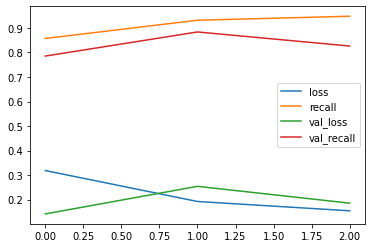

In [58]:
model_loss.plot()

In [59]:
model.evaluate(X_train, y_train)

# loss ve recall degerlerim - train seti icin

6088/6088 [==============================] - 73s 12ms/step - loss: 0.2048 - recall: 0.9801


[0.20476296544075012, 0.980074942111969]

In [60]:
model.evaluate(X_test, y_test)

# loss ve val_recall degerlerim - test seti icin

1522/1522 [==============================] - 18s 12ms/step - loss: 0.2541 - recall: 0.8837


[0.25410982966423035, 0.8837294578552246]

In [61]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
y_train_pred = model.predict(X_train) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

[[168190  15666]
 [   218  10723]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    183856
           1       0.41      0.98      0.57     10941

    accuracy                           0.92    194797
   macro avg       0.70      0.95      0.76    194797
weighted avg       0.97      0.92      0.93    194797



In [62]:
y_pred = model.predict(X_test) >= 0.5

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

# burada 1 label'inin skorlarini takip eder, onun icin yukarida map islemini yaptik

[[41265  4700]
 [  318  2417]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     45965
           1       0.34      0.88      0.49      2735

    accuracy                           0.90     48700
   macro avg       0.67      0.89      0.72     48700
weighted avg       0.96      0.90      0.92     48700



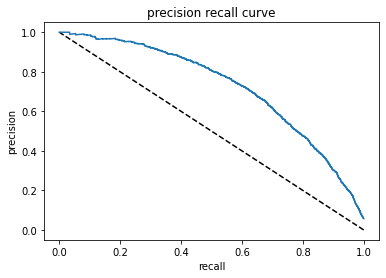

In [63]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_pred_proba = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba,)
plt.plot([1,0],[0,1],'k--')
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision recall curve')
plt.show()

In [64]:
average_precision_score(y_test, y_pred_proba)

0.7228285300785171

##Scores without sample_weight

In [ ]:
y_train_pred = model.predict(X_train) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

[[182573   1283]
 [  2146   8795]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    183856
           1       0.87      0.80      0.84     10941

    accuracy                           0.98    194797
   macro avg       0.93      0.90      0.91    194797
weighted avg       0.98      0.98      0.98    194797



In [ ]:
y_pred = model.predict(X_test) >= 0.5

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

# class weight kullanmasaydik overfitting olusuyor

[[45310   655]
 [ 1015  1720]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     45965
           1       0.72      0.63      0.67      2735

    accuracy                           0.97     48700
   macro avg       0.85      0.81      0.83     48700
weighted avg       0.96      0.97      0.96     48700



## Base model without sample weights


model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens))

model.add(Dropout(0.5))

model.add(GRU(units=48, return_sequences=True))

model.add(Dropout(0.5))

model.add(GRU(units=12))

model.add(Dense(1, activation='sigmoid'))


optimizer = Adam(learning_rate=0.001)


model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['Recall'])


model.fit(X_train, y_train, epochs=1, batch_size=128,
         validation_data=(X_test, y_test))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
y_train_pred = model.predict(X_train) >= 0.5

print(confusion_matrix(y_train, y_train_pred))
print("-------------------------------------------------------")
print(classification_report(y_train, y_train_pred))

In [ ]:
y_pred = model.predict(X_test) >= 0.5

print(confusion_matrix(y_test, y_pred))
print("-------------------------------------------------------")
print(classification_report(y_test, y_pred))

## Model Saving

In [65]:
model.save('review_hepsiburada.h5')

##Loading Model

In [67]:
from tensorflow.keras.models import load_model
model_review = load_model('/content/review_hepsiburada.h5')

## Predicton

In [68]:
review1 = "çok beğendim herkese tavsiye ederim"
review2 = "süper ürün aynı gün elime geçti"
review3 = "büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım"
review4 = "kelimelerle tarif edilemez"
review5 = "tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten"
review6 = "hiç resimde gösterildiği gibi değil"
review7 = "kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım teşekkürler"
review8 = "hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum"
review9 = "tam bir fiyat performans ürünü"
review10 = "beklediğim gibi çıkmadı"
review11 = "on numara beş yıldız"
review12 = "üründe sıkıntı var"
review13 = "televizyonun görüntü kalitesi çok kötü, dün akşam evde arkadaşlarla toplandık. yedik, içtik, sohbet ettik. Sonra televizyonda Türkiye - İngiltere maçını seyrettik. "
review14 = '1 gün gibi kısa bir sürede elime geçti. Ve bu fıyata süper bir ürün tavsiye ederim. Lakin eli büyük olan kişiler daha büyük modelini tercih edebilirler ortaboy ürün. Teşekkürler '
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10, review11, review12, review13, review14]

In [69]:
tokens = tokenizer.texts_to_sequences(reviews)

In [70]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens)
tokens_pad.shape

(14, 61)

In [71]:
(model_review.predict(tokens_pad) > 0.5).astype("int")

# 0 olumlu, 1 olumsuz

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0]])

In [74]:
model_review.predict(tokens_pad)

array([[0.00739111],
       [0.47897187],
       [0.99426997],
       [0.04986176],
       [0.92447126],
       [0.98751885],
       [0.42908674],
       [0.97447544],
       [0.13374563],
       [0.8551416 ],
       [0.01112767],
       [0.5262802 ],
       [0.97815496],
       [0.09357192]], dtype=float32)